## LightGBM notebook

After preprocessing and feature engineering, we use Optuna to determine hyperparameters for our LightGBM model.  It produces a RMSLE of 0.05921, which is 1314/4318 in the Kaggle competition.  For explainability, we examine feature importance, residual plots, and SHAP values.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns
import optuna
import lightgbm as lgb
import shap

In [4]:
train = pd.read_csv("train_pp.csv")
test = pd.read_csv("test_pp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,36,189,82,26,101,41.0,5.017280
1,0,64,163,60,8,85,39.7,3.555348
2,0,51,161,64,7,84,39.8,3.401197
3,1,20,192,90,25,105,40.7,4.948760
4,0,38,166,61,25,102,40.6,4.990433


In [5]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, and Body_Temp squared
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)
    df_new['Body_Temp_-_min_sq'] = (df_new['Body_Temp']-df_new['Body_Temp'].min())**2

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

Use Optuna to select model parameters!

In [ ]:
X = add_feats(train, numerical_features)
y = train['Calories']

def objective(trial):
    
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, step=0.005),
        # 'subsample': 0.8,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 128, 512),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': 0.8, # same as subsample
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        #'min_child_samples': 20, # trial.suggest_int('min_child_samples', 5, 100)
    }

    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=724)
    
    scores = []

    # Perform cross-validation manually
    for train_idx, valid_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        
        # Create Dataset for validation to enable early stopping
        dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=['Sex'])
        dtest = lgb.Dataset(X_val, label=y_val, categorical_feature=['Sex'])

        # Initialize and train the model with the suggested hyperparameters
        # Use high boost rounds that will more than likely be stopped by early stopping rounds
        model = lgb.train(params, dtrain, num_boost_round=2000,
                          valid_sets=dtest,
                          callbacks=[lgb.early_stopping(stopping_rounds=40, verbose=False)])
        
        # print("Stopped at iteration:", model.best_iteration)

        # evaluate
        predictions = model.predict(X_val, num_iteration=model.best_iteration)
        
        # Calculate the score
        score = rmse(y_val, predictions)
        scores.append(score)
    

    # Calculate mean RMSE
    error = np.mean(scores)
    return error




if __name__ == "__main__":
    study = optuna.create_study(direction="minimize", study_name='CV_3_early_stop_ss', storage="sqlite:///lgbm.db", load_if_exists=True)
    study.optimize(objective, n_trials=4000, timeout=43200)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2025-06-23 22:38:57,048] A new study created in RDB with name: CV_3_early_stop_ss
[I 2025-06-23 22:40:54,834] Trial 0 finished with value: 0.06000311992016211 and parameters: {'learning_rate': 0.015, 'lambda_l1': 4.69930194944898e-06, 'lambda_l2': 0.92298596970321, 'num_leaves': 254, 'feature_fraction': 0.44121695775675634, 'bagging_freq': 7}. Best is trial 0 with value: 0.06000311992016211.
[I 2025-06-23 22:41:15,717] Trial 1 finished with value: 0.061619782826213866 and parameters: {'learning_rate': 0.125, 'lambda_l1': 4.107514583245556e-08, 'lambda_l2': 9.34054398337385e-06, 'num_leaves': 463, 'feature_fraction': 0.44205343487516463, 'bagging_freq': 7}. Best is trial 0 with value: 0.06000311992016211.
[I 2025-06-23 22:42:19,925] Trial 2 finished with value: 0.06072445121795833 and parameters: {'learning_rate': 0.10500000000000001, 'lambda_l1': 4.709265949589492, 'lambda_l2': 4.4200451978997e-06, 'num_leaves': 168, 'feature_fraction': 0.6672968351273589, 'bagging_freq': 7}. Best i

Number of finished trials:  258
Best trial:
  Value: 0.05992058032979758
  Params: 
    learning_rate: 0.005
    lambda_l1: 1.0634452742400607e-05
    lambda_l2: 0.007514325347682328
    num_leaves: 325
    feature_fraction: 0.5061026371000865
    bagging_freq: 4


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4469
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 24
[LightGBM] [Info] Start training from score 4.140895
Stopped at iteration: 1905
Train prediction: 0.05278971935514258
Test prediction: 0.059921195569723466


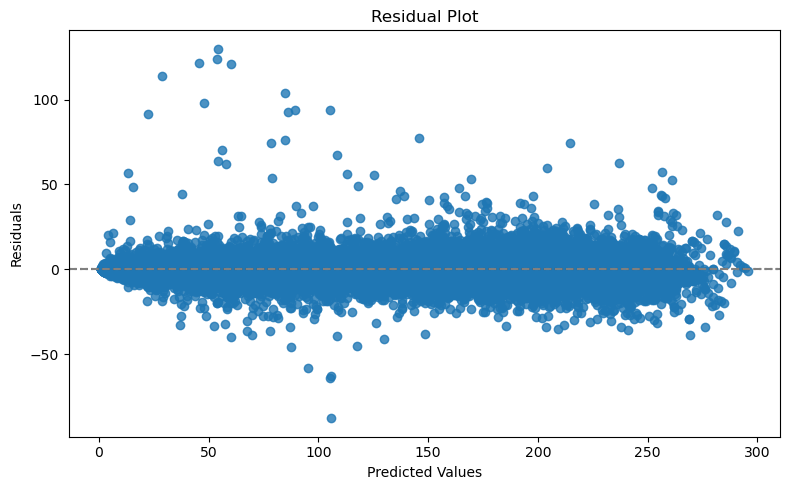

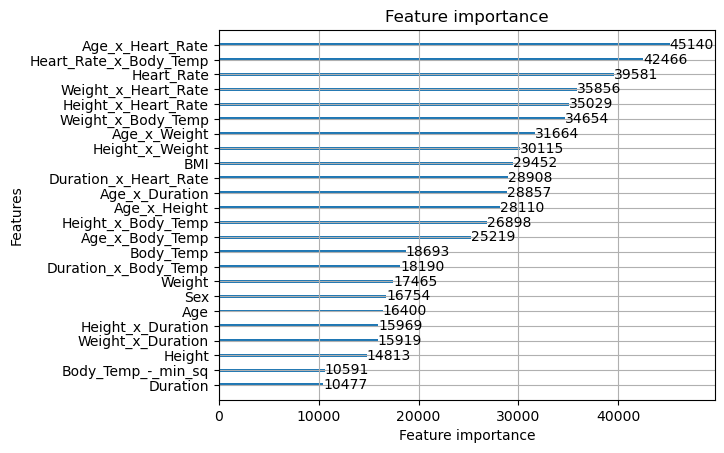

       id    Calories
0  750000   27.701990
1  750001  108.257479
2  750002   87.756264
3  750003  126.415430
4  750004   75.629502

count    250000.000000
mean         88.165346
std          62.242168
min           0.903503
25%          34.039331
50%          76.465091
75%         135.411781
max         292.921781
Name: Calories, dtype: float64


In [ ]:
# Kaggle score 0.05921 pub, 0.05754 priv, lgb_prediction_27.csv

# Best trial:
#   Value: 0.05992058032979758
#   Params: 
#     learning_rate: 0.005
#     lambda_l1: 1.0634452742400607e-05
#     lambda_l2: 0.007514325347682328
#     num_leaves: 325
#     feature_fraction: 0.5061026371000865
#     bagging_freq: 4


X = add_feats(train, numerical_features)
y = train['Calories']



# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)

dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=['Sex'])
dtest = lgb.Dataset(X_test, label=y_test, categorical_feature=['Sex'])

# Define parameters
params = {
    'learning_rate': 0.005,
    'lambda_l1': 1.0634452742400607e-05,
    'lambda_l2': 0.007514325347682328,
    'num_leaves': 325,
    'feature_fraction': 0.5061026371000865,
    'bagging_fraction': 0.8, # same as subsample
    'bagging_freq': 4,
    #'min_child_samples': 16,
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
}

# Initialize and train the model with the suggested hyperparameters
model = lgb.train(params, dtrain, num_boost_round=4000,
                    valid_sets=dtest,
                    callbacks=[lgb.early_stopping(stopping_rounds=40, verbose=False)])
        
print("Stopped at iteration:", model.best_iteration)

# Make predictions
train_pred = model.predict(X_train, num_iteration=model.best_iteration)
test_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1
train_pred[train_pred > 320] = 300
test_pred[test_pred < 0] = 1
test_pred[test_pred > 320] = 300

print("Train prediction:", rmse(train_pred, y_train))
print("Test prediction:", rmse(test_pred, y_test))



# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(y_test))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


lgb.plot_importance(model)
plt.show()



# make the submission file!
testsub = add_feats(test, numerical_features)

pred = model.predict(testsub, num_iteration=model.best_iteration, categorical_feature=['Sex'])

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("lgb_prediction_27.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

### SHAP values for explainability

Which features contribute most to the models performance?

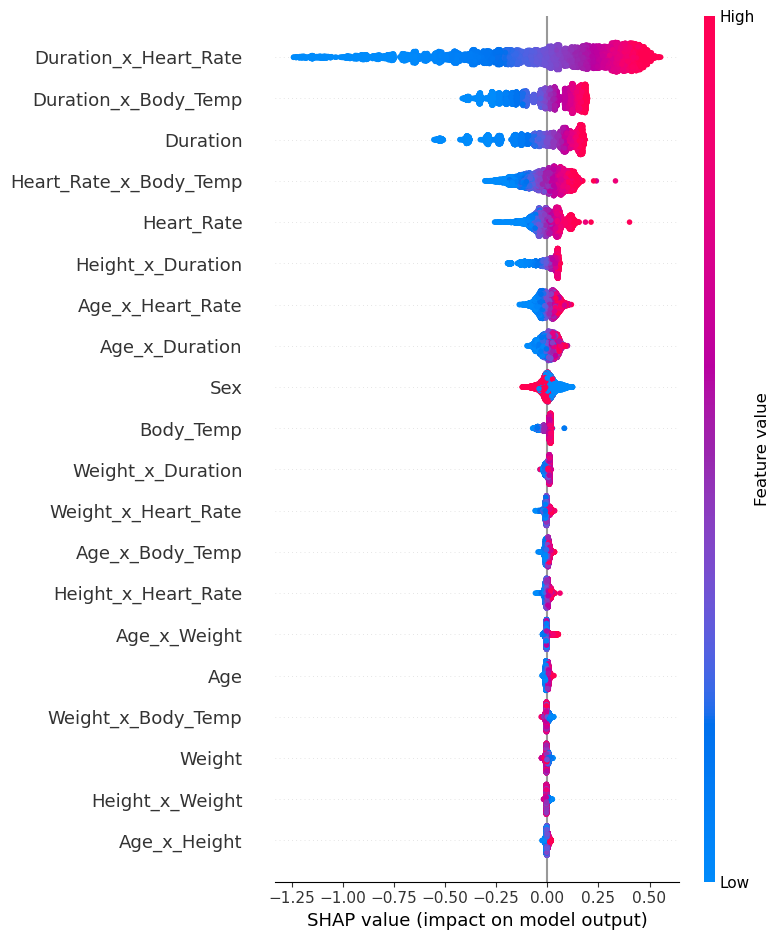

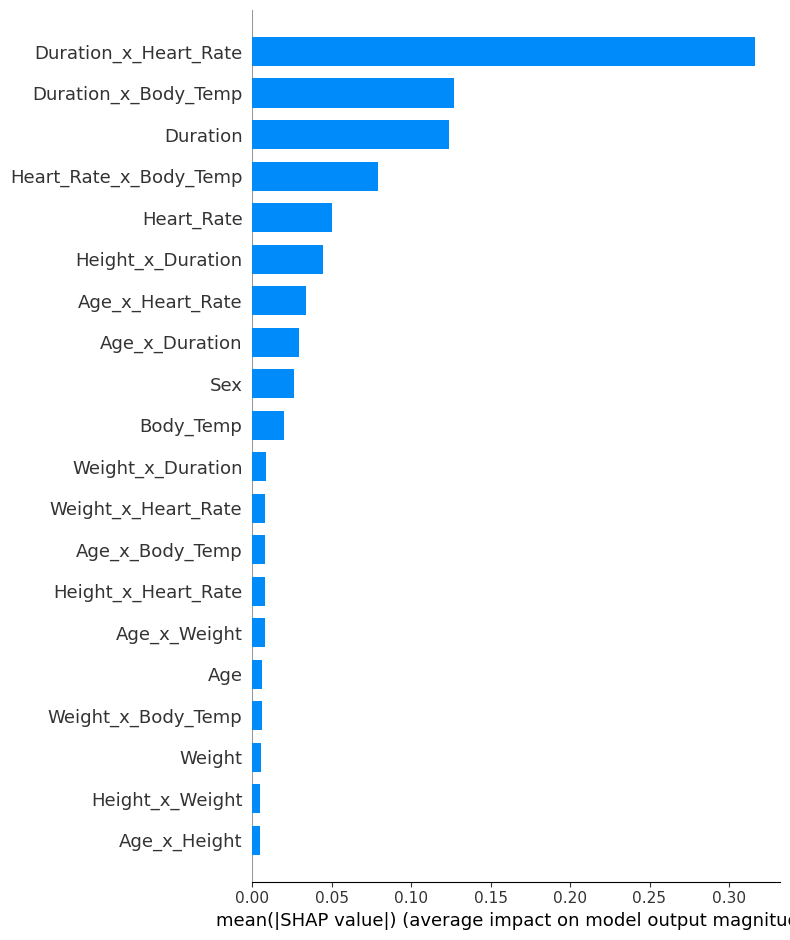

In [11]:
explainer  = shap.TreeExplainer(model)

# compute SHAP on 10000-point sample
X_small    = X_train.sample(10000, random_state=724)
shap_vals  = explainer.shap_values(X_small)

# visualize
shap.summary_plot(shap_vals, X_small)
shap.summary_plot(shap_vals, X_small, plot_type='bar')

#### SHAP Dependence plots

How are features related?

In this plot, we can see that Duration and Heart_Rate appear to be related; as Duration increases, so does Heart_Rate, and the SHAP values.

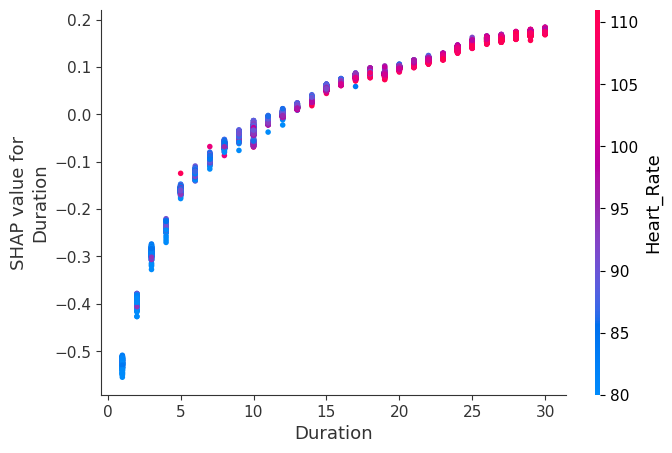

In [12]:
shap.dependence_plot(
    'Duration',
    shap_vals,
    X_small,
   interaction_index='Heart_Rate'  # name or index of the feature to color by
)

We can see the relation between Duration_x_Heart_Rate and increases SHAP values.  Moreover, it appears that Sex (red for male) and Duration_x_Heart_Rate have no relation.

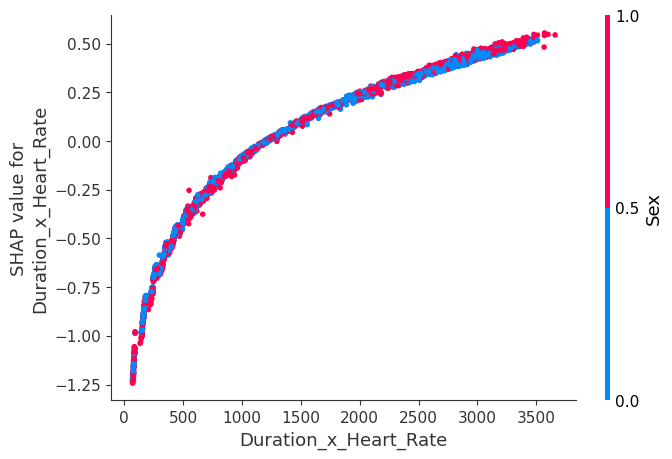

In [13]:
shap.dependence_plot(
    'Duration_x_Heart_Rate',
    shap_vals,
    X_small,
   interaction_index='Sex'  # name or index of the feature to color by
)

We can see that Age has little effect on SHAP values (notice the scale).

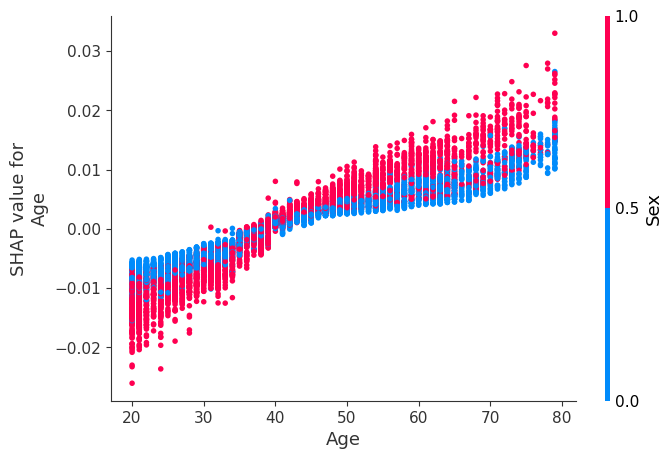

In [14]:
shap.dependence_plot(
    'Age',
    shap_vals,
    X_small,
   interaction_index='Sex'  # name or index of the feature to color by
)

#### SHAP waterfall plots

Below, $E[f(X)]$ is the mean value of the predicted log-transformed Calories and $f(x)$ is the predicted value of (log-transformed) Calories for the $i^{\mathrm{th}}$ entry of our dataset.  The red/blue arrows with a number inside represent that features impact on the difference between the mean value and predicted value.

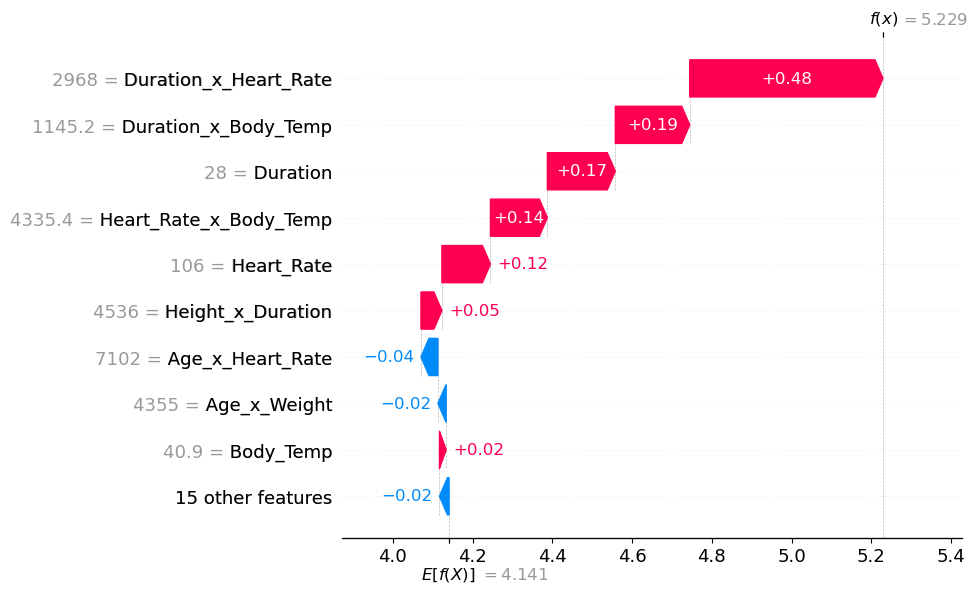

In [15]:
i = 0

shap.plots.waterfall(
    shap.Explanation(
      values=shap_vals[i], 
      base_values=explainer.expected_value, 
      data=X_test.iloc[i]
    )
)